In [1]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


from collections import defaultdict
import json

import seisbench.models as sbm

cuda


## Loading the trained models

In [2]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)

/tmp/ipykernel_995963/3388980850.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_Seis

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [43]:
def run_inference_with_stride(stream, model, processor,
                              starttime,
                              sample_rate=50,
                              window_len=5000,
                              stride_samples=1000):
    """
    Run your inference loop with a given stride (in samples).
    Returns:
      t_windows: numpy array of shape (n_windows,)  → the start time (sec) of each window
      probs_all: numpy array of shape (n_windows, n_classes)  → softmax probabilities per window
    """
    # Convert stream to a 2D NumPy array of shape (n_channels, n_samples)
    data = np.array(stream)  # assume already resampled to `sample_rate`

    n_samples = data.shape[-1]
    n_channels = data.shape[0]

    model.eval()
    device = next(model.parameters()).device  # assume model is already on 'cuda'

    # Pre-allocate lists
    t_list = []
    prob_list = []

    # For each window start index i
    for i in range(0, n_samples, stride_samples):
        if i + window_len > n_samples:
            break

        # Compute the window's start time in seconds relative to starttime
        # (i samples / sample_rate samples/sec)
        t_sec = i / sample_rate

        # Slice out the window (C, T)
        waveform_np = data[:, i : i + window_len]  # shape (3, 5000) for example

        # Convert to torch, preprocess, spectrogram, normalize
        waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32).to(device)
        processed = processor(waveform_tensor)  # shape (3, window_len)
        processed = processed.unsqueeze(0)
        spec_local = compute_spectrogram(processed, sample_rate)   # (1, F, T')
        inputs = normalize_spectrogram_minmax(spec_local[0])       # (F, T')
        

        # Run model
        with torch.no_grad():
            outputs = model(inputs.to(device))  # add batch
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]  # shape (n_classes,)

        # Store
        t_list.append(t_sec)
        prob_list.append(probs)

    t_windows = np.array(t_list)                 # shape (n_windows,)
    probs_all = np.vstack(prob_list)             # shape (n_windows, n_classes)
    return t_windows, probs_all


## Testing for a surface event

/tmp/ipykernel_995963/3886983739.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


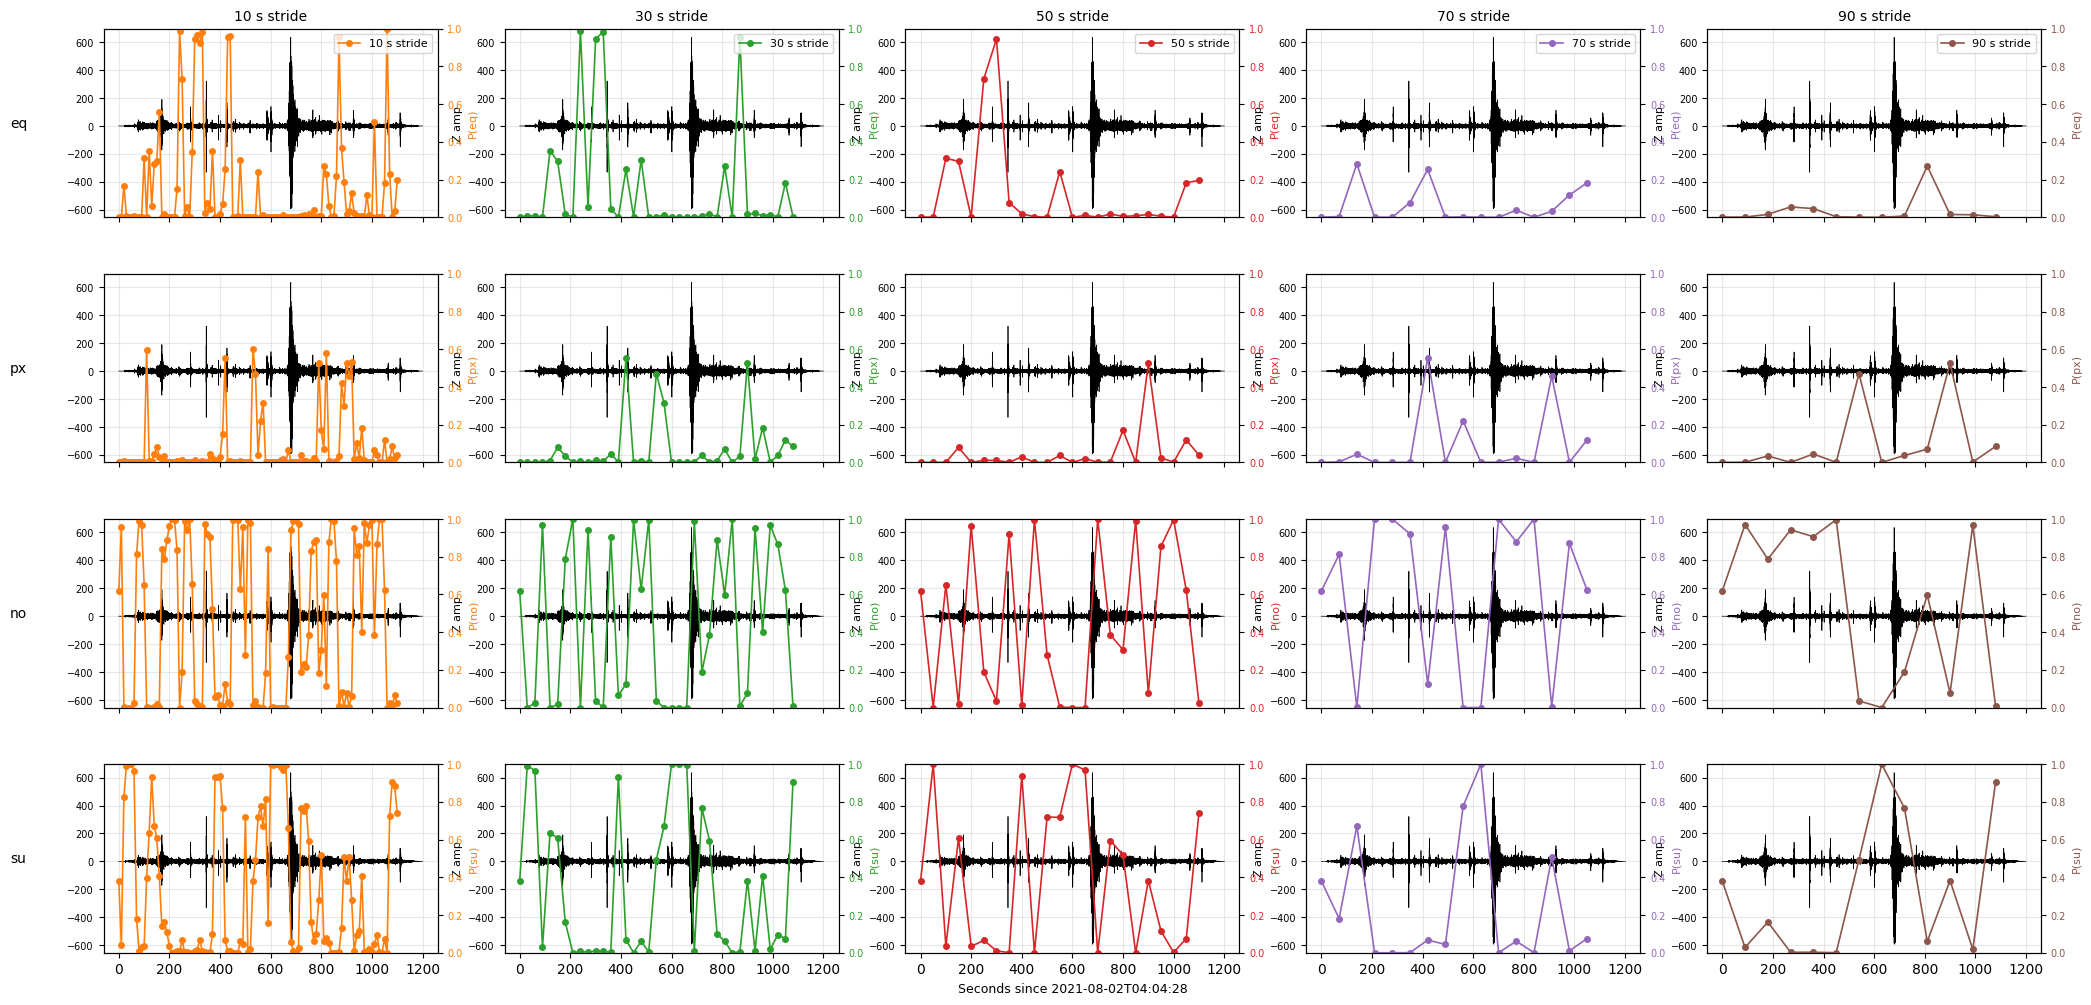

In [67]:
# ─────────────────────────────────────────────────────────────────
# 1 ▪ Download waveform, preprocess, and extract Z‐component
# ─────────────────────────────────────────────────────────────────
starttime = obspy.UTCDateTime("2021-08-02T04:14:28Z")
stream = client.get_waveforms(
    network="UW", station="RCM",
    channel="HH?", location="",
    starttime=starttime - 600,
    endtime=starttime + 600
)

# Basic detrend, taper, bandpass, resample
stream.detrend("linear")
stream.taper(0.1)
stream.filter("bandpass", freqmin=1, freqmax=10)
stream.resample(50)

# Extract Z‐component
st_z = stream.select(component="Z")[0]
sr   = st_z.stats.sampling_rate  # should be 50 Hz after resample
z    = st_z.data.astype(float)
t_z  = np.arange(len(z)) / sr     # time axis in seconds

# ─────────────────────────────────────────────────────────────────
# 2 ▪ Run inference at 5 different strides
# ─────────────────────────────────────────────────────────────────
# Define strides (in samples) for 10 s, 30 s, 50 s, 70 s, 90 s
stride_secs = [10, 30, 50, 70, 90]
strides     = [int(s * sr) for s in stride_secs]  # e.g. [500, 1500, 2500, 3500, 4500]

# We’ll store result in lists so we can index by column:
t_list     = []
probs_list = []

for stride_samples in strides:
    t_w, p_w = run_inference_with_stride(
        stream, model, processor, starttime,
        sample_rate=sr, window_len=5000, stride_samples=stride_samples
    )
    t_list.append(t_w)     # shape: (n_windows_j,)
    probs_list.append(p_w) # shape: (n_windows_j, n_classes)

# ─────────────────────────────────────────────────────────────────
# 3 ▪ Prepare plotting: classes, colors, markers
# ─────────────────────────────────────────────────────────────────
class_names = ["eq", "px", "no", "su"]

# Choose one distinct color for each stride column
# (You can pick any 5 distinct Matplotlib colors.)
colors = ["C1", "C2", "C3", "C4", "C5"]
marker = "o"  # same marker for all, but color differs per column

# ─────────────────────────────────────────────────────────────────
# 4 ▪ Create 4×5 subplots
# ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=5,
    figsize=(25, 12),
    sharex=True,
    gridspec_kw={"hspace": 0.3, "wspace": 0.2}
)

for col_idx in range(5):
    t_prob = t_list[col_idx]       # times for this stride
    probs  = probs_list[col_idx]   # shape (n_windows, 4)

    for row_idx, cls in enumerate(class_names):
        ax_wave = axes[row_idx, col_idx]       # subplot for (class, stride)
        ax_prob = ax_wave.twinx()              # twin y-axis for probability

        # 1) Plot the Z‐waveform in black
        ax_wave.plot(t_z, z, color="k", lw=0.5)
        ax_wave.set_ylabel("Z amp", color="k", fontsize=8)
        ax_wave.tick_params(axis="y", labelcolor="k", labelsize=7)

        # 2) Plot the probability for this class & this stride
        ax_prob.plot(
            t_prob,
            probs[:, row_idx],
            color=colors[col_idx],
            marker=marker,
            markersize=4,
            linestyle="-",
            lw=1.2,
            label=f"{stride_secs[col_idx]} s stride"
        )
        ax_prob.set_ylim(0, 1)
        ax_prob.set_ylabel(f"P({cls})", color=colors[col_idx], fontsize=8)
        ax_prob.tick_params(axis="y", labelcolor=colors[col_idx], labelsize=7)

        # 3) Grid and titles
        ax_wave.grid(alpha=0.3)
        if row_idx == 0:
            # Only top‐row gets a column title
            ax_wave.set_title(f"{stride_secs[col_idx]} s stride", fontsize=10)

        # 4) Add a legend only in the top‐row, so we don’t clutter
        if row_idx == 0:
            ax_prob.legend(loc="upper right", fontsize=8)

# ─────────────────────────────────────────────────────────────────
# 5 ▪ Label the left‐side y‐axis rows and the bottom x‐axis
# ─────────────────────────────────────────────────────────────────
for row_idx, cls in enumerate(class_names):
    axes[row_idx, 0].set_ylabel(f"{cls}", rotation=0, labelpad=35,
                                va="center", fontsize=10)

# Bottom row: shared x‐label
axes[-1, 2].set_xlabel(f"Seconds since {st_z.stats.starttime.isoformat()}",
                       fontsize=9)

plt.tight_layout()
plt.show()


## Testing for an earthquake

/tmp/ipykernel_995963/2594794669.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


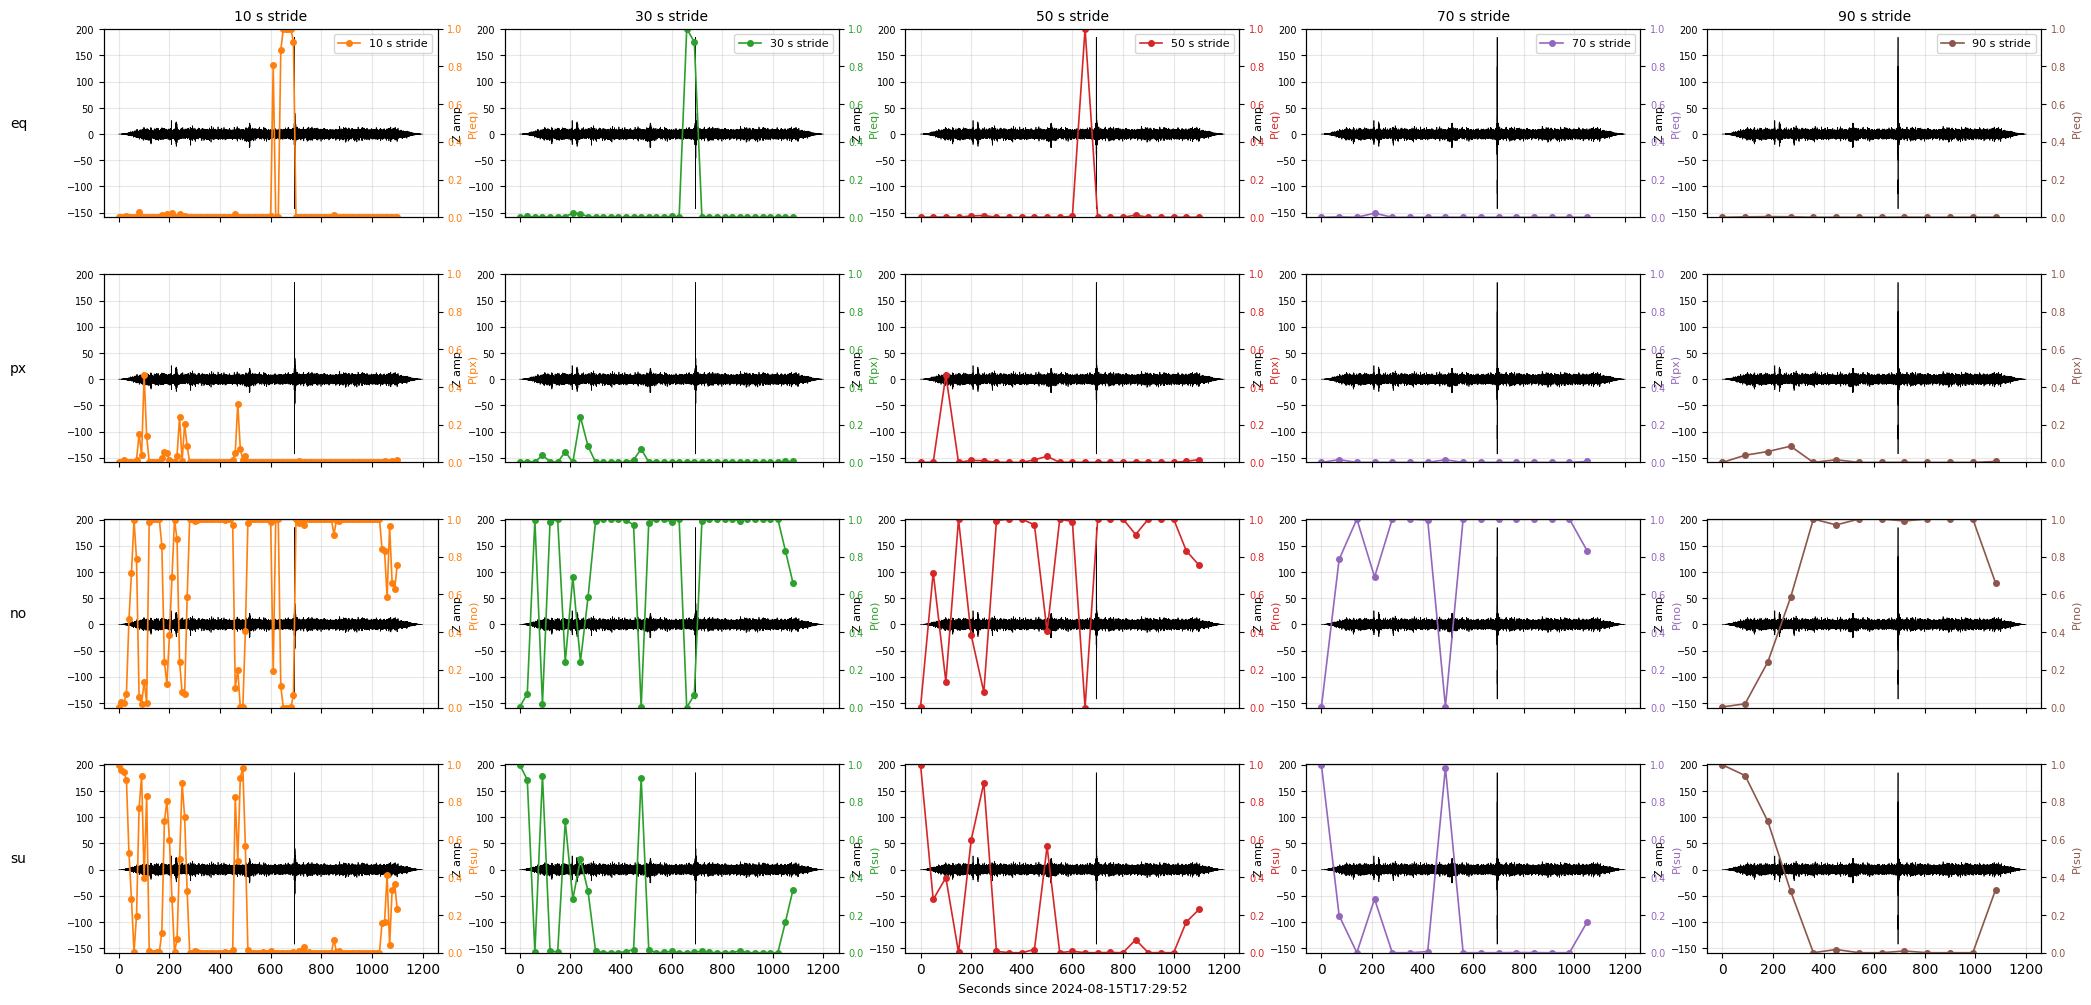

In [69]:

# ─────────────────────────────────────────────────────────────────
# 1 ▪ Download waveform, preprocess, and extract Z‐component
# ─────────────────────────────────────────────────────────────────
starttime = obspy.UTCDateTime(2024, 8, 15, 17, 39, 52)
stream = client.get_waveforms(
    network="UW", station="RER",
    channel="HH?", location="",
    starttime=starttime - 600,
    endtime=starttime + 600
)

# Basic detrend, taper, bandpass, resample
stream.detrend("linear")
stream.taper(0.1)
stream.filter("bandpass", freqmin=1, freqmax=10)
stream.resample(50)

# Extract Z‐component
st_z = stream.select(component="Z")[0]
sr   = st_z.stats.sampling_rate  # should be 50 Hz after resample
z    = st_z.data.astype(float)
t_z  = np.arange(len(z)) / sr     # time axis in seconds

# ─────────────────────────────────────────────────────────────────
# 2 ▪ Run inference at 5 different strides
# ─────────────────────────────────────────────────────────────────
# Define strides (in samples) for 10 s, 30 s, 50 s, 70 s, 90 s
stride_secs = [10, 30, 50, 70, 90]
strides     = [int(s * sr) for s in stride_secs]  # e.g. [500, 1500, 2500, 3500, 4500]

# We’ll store result in lists so we can index by column:
t_list     = []
probs_list = []

for stride_samples in strides:
    t_w, p_w = run_inference_with_stride(
        stream, model, processor, starttime,
        sample_rate=sr, window_len=5000, stride_samples=stride_samples
    )
    t_list.append(t_w)     # shape: (n_windows_j,)
    probs_list.append(p_w) # shape: (n_windows_j, n_classes)

# ─────────────────────────────────────────────────────────────────
# 3 ▪ Prepare plotting: classes, colors, markers
# ─────────────────────────────────────────────────────────────────
class_names = ["eq", "px", "no", "su"]

# Choose one distinct color for each stride column
# (You can pick any 5 distinct Matplotlib colors.)
colors = ["C1", "C2", "C3", "C4", "C5"]
marker = "o"  # same marker for all, but color differs per column

# ─────────────────────────────────────────────────────────────────
# 4 ▪ Create 4×5 subplots
# ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=5,
    figsize=(25, 12),
    sharex=True,
    gridspec_kw={"hspace": 0.3, "wspace": 0.2}
)

for col_idx in range(5):
    t_prob = t_list[col_idx]       # times for this stride
    probs  = probs_list[col_idx]   # shape (n_windows, 4)

    for row_idx, cls in enumerate(class_names):
        ax_wave = axes[row_idx, col_idx]       # subplot for (class, stride)
        ax_prob = ax_wave.twinx()              # twin y-axis for probability

        # 1) Plot the Z‐waveform in black
        ax_wave.plot(t_z, z, color="k", lw=0.5)
        ax_wave.set_ylabel("Z amp", color="k", fontsize=8)
        ax_wave.tick_params(axis="y", labelcolor="k", labelsize=7)

        # 2) Plot the probability for this class & this stride
        ax_prob.plot(
            t_prob,
            probs[:, row_idx],
            color=colors[col_idx],
            marker=marker,
            markersize=4,
            linestyle="-",
            lw=1.2,
            label=f"{stride_secs[col_idx]} s stride"
        )
        ax_prob.set_ylim(0, 1)
        ax_prob.set_ylabel(f"P({cls})", color=colors[col_idx], fontsize=8)
        ax_prob.tick_params(axis="y", labelcolor=colors[col_idx], labelsize=7)

        # 3) Grid and titles
        ax_wave.grid(alpha=0.3)
        if row_idx == 0:
            # Only top‐row gets a column title
            ax_wave.set_title(f"{stride_secs[col_idx]} s stride", fontsize=10)

        # 4) Add a legend only in the top‐row, so we don’t clutter
        if row_idx == 0:
            ax_prob.legend(loc="upper right", fontsize=8)

# ─────────────────────────────────────────────────────────────────
# 5 ▪ Label the left‐side y‐axis rows and the bottom x‐axis
# ─────────────────────────────────────────────────────────────────
for row_idx, cls in enumerate(class_names):
    axes[row_idx, 0].set_ylabel(f"{cls}", rotation=0, labelpad=35,
                                va="center", fontsize=10)

# Bottom row: shared x‐label
axes[-1, 2].set_xlabel(f"Seconds since {st_z.stats.starttime.isoformat()}",
                       fontsize=9)

plt.tight_layout()
plt.show()
